In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
#from model.featureConfig import FeatureConfig_G3

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:03<00:00, 782.92it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:24<00:00,  2.02it/s]


In [4]:
ftr_list = ['num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num',
            'last_access', 
            'active',
            'usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'num_pass', 'num_replay', 'num_fail', 'rate_pass', 'rate_fail',
            'num_assess', 'assess', 'num_replay', 'rate_assess',
            'sum_help',
            'usage_sd2', 'num_sd2',
            'usage_sd0', 'num_sd0',
            'rate_stackDepth23_num', 'rate_stackDepth23_usage',
            'age',
            'mark_complete', 'mark_incomplete',
            'progress', 'progress_delta',
            'calendar_month',
           ]

data_engine.select_features(ftr_list)

X = data_engine.data_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

## Feature Distribution (Raw)

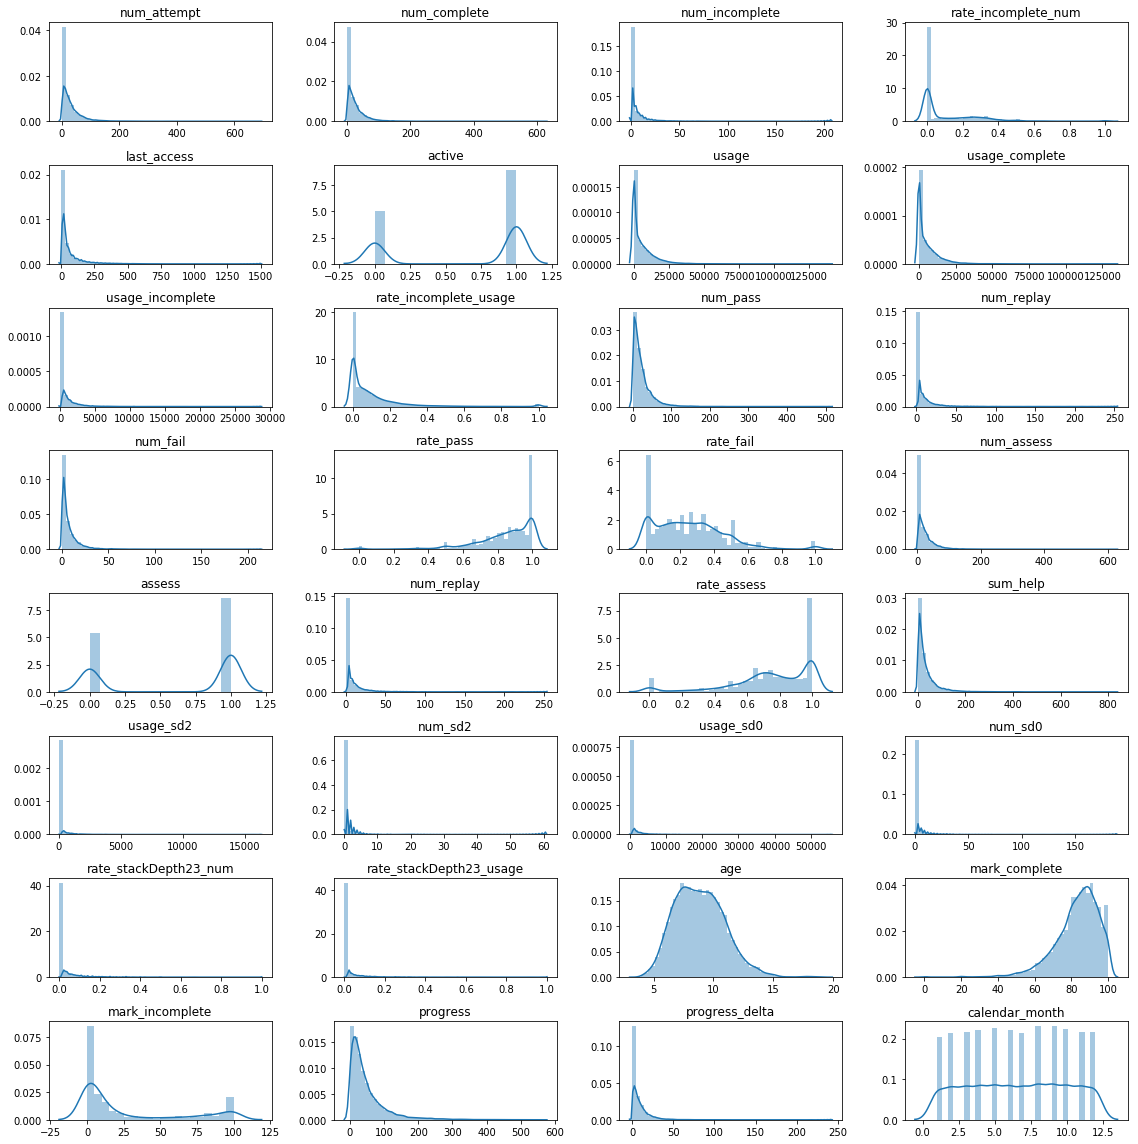

In [5]:
ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz1, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

## Groups

In [6]:
mask_inactive = df_whizz1.active==0
mask_churn = df_whizz1.churn==1

print('Churn rate for inactive subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_inactive&mask_churn].shape[0]/df_whizz1[mask_inactive].shape[0]*100))
print('Churn rate for active subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_inactive&mask_churn].shape[0]/df_whizz1[~mask_inactive].shape[0]*100))

Churn rate for inactive subscribers = 22.99%.
Churn rate for active subscribers = 10.46%.


In [7]:
df_whizz1.columns

Index(['num_attempt', 'num_complete', 'num_incomplete', 'rate_incomplete_num',
       'churn', 'last_access', 'active', 'calendar_month', 'holiday',
       'usage_complete', 'usage_incomplete', 'usage', 'rate_incomplete_usage',
       'progress', 'progress_delta', 'age', 'num_pass', 'num_fail', 'assess',
       'num_assess', 'num_replay', 'rate_assess', 'rate_pass', 'rate_fail',
       'rate_fwrd', 'rate_back', 'num_sd0', 'num_sd1', 'num_sd2', 'help_sd0',
       'help_sd1', 'help_sd2', 'usage_sd0', 'usage_sd1', 'usage_sd2',
       'sum_help', 'rate_stackDepth23_num', 'rate_stackDepth23_usage',
       'mark_complete', 'mark_incomplete'],
      dtype='object')

## Initial Diagnostics of Features

In [8]:
df_whizz_inactive = df_whizz1[mask_inactive][['churn', 'last_access', 'calendar_month', 'holiday', 'age', 'progress']]

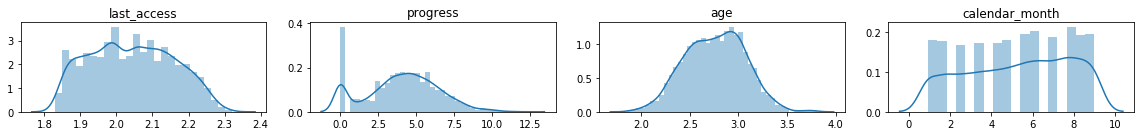

In [9]:
ftr_list_independent = []

ftr_list_multivariate = ['last_access', 'progress', 'age', 'calendar_month']

ftr_list = ftr_list_independent + ftr_list_multivariate

ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz_inactive, ftr_list, 4, cfg, 
    transform=True, ftr_list_nontransform=ftr_list_nontransform)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

X = np.array(df_whizz_inactive[ftr_list_multivariate]+1)
Xt = X
for i in range(0, X.shape[1]):
    xt, _ = stats.boxcox(X[:,i])
    Xt[:, i] = xt
Xt_scaled = MinMaxScaler().fit(Xt).transform(Xt)

y = df_whizz_inactive.churn.values

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Initialization 0
  Iteration 0	 time lapse 0.01596s	 ll change inf
  Iteration 100	 time lapse 0.72107s	 ll change 9.58513
  Iteration 200	 time lapse 0.73304s	 ll change 0.00356
  Iteration 300	 time lapse 0.71409s	 ll change 0.00090
  Iteration 400	 time lapse 0.72107s	 ll change 0.00044
  Iteration 500	 time lapse 0.72107s	 ll change 0.00024
Initialization converged: True	 time lapse 4.24364s	 ll 27094.15200


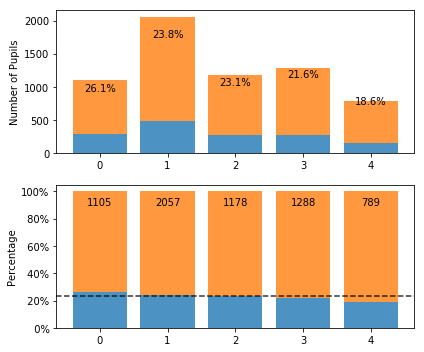

In [22]:
n_components = 10
n_features = len(ftr_list_multivariate)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-4, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(Xt_scaled)

group_m = dpgmm.predict(Xt_scaled)

utility.plotlib.component_bar(y, group_m, n_components)

In [23]:
n_var_indep = len(ftr_list_independent)
# Combine the group assignemnts from multivariate Gaussian features and independent features
group = []
col_name = []
group.append(group_m)
col_name.append('multi')
for i_var in range(n_var_indep):
    ftr_str = ftr_list_independent[i_var]
    m, g = independent_component(ftr_str, plot=False)
    group.append(g)
    col_name.append('indep'+str(i_var))

In [24]:
# Identify unique groups/labels and frequency
label = np.array(group).transpose()
unq_rows, count = np.unique(label, axis=0, return_counts=True)
map_group_count = {tuple(i):j for i,j in zip(unq_rows,count)}

In [25]:
# Compute churn rate within each group
map_group_churn = {}
for k in range(0, len(unq_rows)):
    indices = [i for i, x in enumerate(label.tolist()) if x==unq_rows[k].tolist()]
    l = y[indices]
    map_group_churn[tuple(unq_rows[k])] = l.sum()*1. / len(l)

In [26]:
# Construct the grouping data frame
df_grouping = pd.DataFrame(unq_rows, columns=col_name)
df_grouping = df_grouping.assign(count=count,
                   churn=list(map_group_churn.values()))
df_grouping.sort_values(by='churn', ascending=False, inplace=True)
df_grouping['cumcount'] = df_grouping['count'].cumsum()

Text(0,0.5,'Group churn rate')

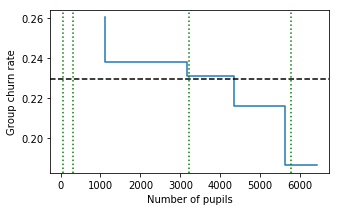

In [27]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.step(df_grouping['cumcount'].values, df_grouping['churn'].values)
ax.axhline(y=y.sum()/len(y), linestyle='--', color='k')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 1), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 5), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 50), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 90), linestyle=':', color='g')
ax.set_xlabel('Number of pupils')
ax.set_ylabel('Group churn rate')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [28]:
agg_anchors = [0, 30, 90, 100]
num_agg = len(agg_anchors) - 1
agg_churn = []
agg_count = []
l = np.arange(0, len(y)) + 1
for i in range(len(agg_anchors)):
    if i==0:
        continue
    else:
        lower = np.percentile(l, agg_anchors[i-1])
        upper = np.percentile(l, agg_anchors[i])
    
    if i==len(agg_anchors)-1:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<=upper)
    else:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<upper)
        
    df_grouping.loc[mask, 'agg'] = i
    df = df_grouping[mask]
    temp = df['churn'] * df['count']
    num_churn = temp.sum()
    agg_count.append(df['count'].sum())
    agg_churn.append(num_churn*1./agg_count[i-1])

data = {'count': agg_count,
        'churn': agg_churn
    }
df_grouping_agg = pd.DataFrame(data)
df_grouping_agg['cumcount'] = df_grouping_agg['count'].cumsum()

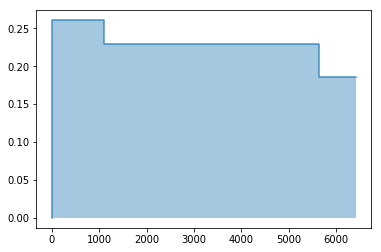

In [29]:
xp = df_grouping_agg['cumcount'].values
yp = df_grouping_agg['churn'].values

xp = np.insert(xp, 0, 0)
yp = np.insert(yp, 0, 0)

plt.fill_between(xp, yp, step='pre', alpha=0.4)
plt.plot(xp, yp, drawstyle="steps", alpha=0.8)
#plt.step(df_countchurn['cumcount'].values, df_countchurn['churn'].values, alpha=0.8)

In [30]:
df_grouping_agg

,churn,count,cumcount
0,0.260633,1105,1105
1,0.229936,4523,5628
2,0.186312,789,6417
